In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *

In [2]:
# Define preprocessing and augmentation for train data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

])



In [3]:
# Define validation transformation with no augmentation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
import os
from dotenv import load_dotenv
from torchvision import datasets

# Load environment variables from the .env file
load_dotenv() 
# load dataset
PATH = os.getenv("DATASET_PATH")
if PATH is None:
    raise ValueError("DATASET_PATH environment variable not set. Check your .env file.")

dataset = datasets.ImageFolder(PATH)

In [5]:
from torch.utils.data import random_split
# split data into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_subset, val_subset = random_split(dataset, [train_size, val_size])

In [6]:
# apply different transforms
train_dataset = datasets.ImageFolder(PATH, transform=train_transform)
val_dataset   = datasets.ImageFolder(PATH, transform=val_transform)

# manually assign the same image indices
train_dataset.samples = [dataset.samples[i] for i in train_subset.indices]
val_dataset.samples   = [dataset.samples[i] for i in val_subset.indices]

In [7]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
print("Classes:", dataset.classes)
print("Class indices:", dataset.class_to_idx)

Classes: ['Backpack', 'Chair', 'File_Cabinet', 'Folder', 'Laptop', 'Mug', 'Notebook', 'Pen', 'Table', 'Trash_Can']
Class indices: {'Backpack': 0, 'Chair': 1, 'File_Cabinet': 2, 'Folder': 3, 'Laptop': 4, 'Mug': 5, 'Notebook': 6, 'Pen': 7, 'Table': 8, 'Trash_Can': 9}


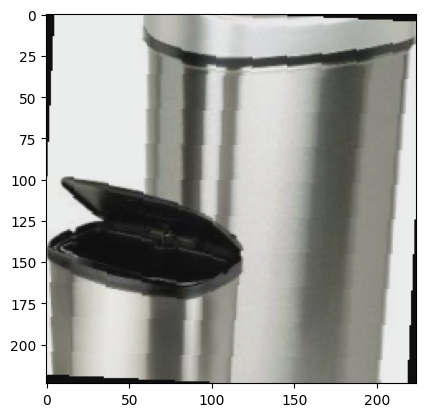

In [13]:
# display image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Show one batch
images, labels = next(iter(train_loader))
imshow(images[2])

SuggestedLRs(valley=0.02290867641568184)

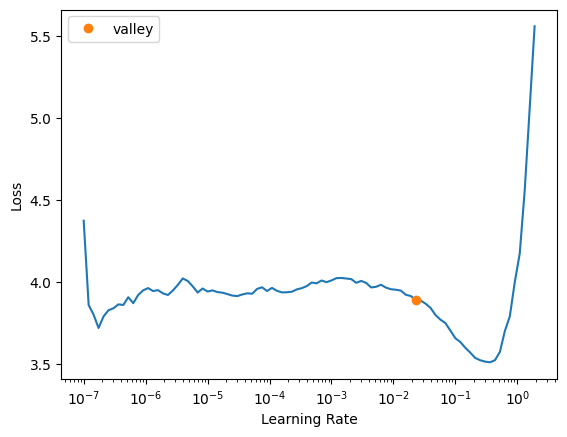

In [10]:
#finding learning rate of resnet34
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_dataset, val_dataset, bs=32, device='cpu')
dls.c = 10
learn = vision_learner(dls, resnet34, metrics=accuracy, loss_func=CrossEntropyLossFlat(),opt_func=SGD)


learn.lr_find()

Take the learning rate before the loss sharply increases so, taking learning rate of 2e-2

In [11]:
# freeze petrained layers
learn.freeze()

# train head for r epoch with learning rate of 2e-2
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.900064,1.073436,0.669811,04:15
1,1.565613,0.570555,0.794340,04:22
2,0.962890,0.485594,0.852830,04:09
3,0.728509,0.460390,0.852830,04:03
4,0.621914,0.452742,0.854717,05:09
